### Figure: Distribution of variability across bathymetric regions and density classes

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
from matplotlib import rcParams
from xhistogram.xarray import histogram as hist
import statsmodels.formula.api as sm
import scipy.io as sio

In [2]:
rcParams.update({'font.size': 14})

In [3]:
# Universal variables
rootdir = 'data/'
yrst = 1958
yrinit = 1976
yrend = 2016
years = np.arange(yrst,yrend+1,1)
years_c = 0.5*(years[:-1]+years[1:])
years_init = np.arange(yrinit,yrend+1,1)
years_init_c = 0.5*(years_init[:-1]+years_init[1:])
bathys = np.array([1,40,51,60,65,76])
bathys_c = 0.5*(bathys[:-1]+bathys[1:])

In [4]:
# Load bathymetry
filepath_zgrid = rootdir+'raw/mesh_zgr.nc'
zgrid = xr.open_dataset(filepath_zgrid).squeeze()
# Load volumetric distribution of subduction location and age from ariane output
filepath_vlag = rootdir+'processed/lagrangian/D4_weights-init_volume_bins-final_x-final_y-final_age-init_t_subset-final_section-7.nc'
vlag = xr.open_dataarray(filepath_vlag)
# Get the Lagrangian data and the grid data on the same grid
# Assign coordinates
zgrid = zgrid.assign_coords({'x':range(1,zgrid.x.size+1),'y':range(1,zgrid.y.size+1)})
depth = np.round(zgrid['gdept_0'])
# Subset grid to region_limits
xmask = (zgrid.x>=np.floor(vlag.final_x_bin.min())) & (zgrid.x<np.ceil(vlag.final_x_bin.max()))
ymask = (zgrid.y>=np.floor(vlag.final_y_bin.min())) & (zgrid.y<np.ceil(vlag.final_y_bin.max()))
zgrid = zgrid.where(xmask & ymask,drop=True)
# Make consistent with lagrangian output
zgrid = zgrid.rename({'x':'final_x_bin','y':'final_y_bin'})
zgrid = zgrid.assign_coords({'final_x_bin':vlag.final_x_bin,'final_y_bin':vlag.final_y_bin})
# Propoagate bathymetry data across time and merge datasets
zgrid['mbathy'] = zgrid.mbathy*xr.ones_like(vlag)
vlag = xr.merge([vlag,zgrid.mbathy])

# Load volumetric distribution of age from ariane output
filepath_vlag_all = rootdir+'processed/lagrangian/D2_weights-init_volume_bins-final_age-init_t_subset-final_section-7_alt.nc'
vlag_all = xr.open_dataarray(filepath_vlag_all)

# Load watermass transformation
filepath_wmt = rootdir+'processed/eulerian/WMT_deepocean_5dglobal_k8_ds0.01.mat'
wmt_vals = sio.loadmat(filepath_wmt)
time = pd.date_range(start='1/10/1958',end='31/12/2015',freq='5D')
wmt = xr.DataArray(wmt_vals['FgW'],dims=['time','dens'],coords={'dens':wmt_vals['g'].squeeze(),'time':time})
                 
# Load NAO data
filepath_nao = rootdir+'raw/nao_station_djfm.txt'
nao_vals = np.loadtxt(filepath_nao,skiprows=1)[:,1]
nao_years = np.loadtxt(filepath_nao,skiprows=1)[:,0]+0.5
nao = xr.DataArray(nao_vals,dims=['years'],coords={'years':nao_years})
nao = nao.sel(years=slice(yrst,yrend))
# Load mixed layer volume from model
# This is the summed volume in the mixed layer north of 45N as defined by the somxl010 variable
# Evaluated in Feb-Mar-Apr of each year
# See calc_Vmld.py for details of calculation
filepath_mld = rootdir+'processed/eulerian/orca025_NA_Vmld.nc'
vmld = xr.open_dataarray(filepath_mld)

In [5]:
# Load Lagrangian volumetric density distribution
filepath_vlag_dens = rootdir+'processed/lagrangian/D3_weights-init_volume_bins-final_age-init_dens-init_t_subset-final_section-7.nc'
vlag_dens = xr.open_dataarray(filepath_vlag_dens)

In [8]:
# PROCESS EULERIAN DATA

### MLD anomalies
# Group data by years and take the mean
vmld_byyear = vmld.groupby(vmld.time_counter.dt.year).mean(dim='time_counter')
# Calculate annual anomaly
vmld_anom = vmld_byyear-vmld_byyear.mean('year')

### WMT anomalies
wmt_byyear = wmt.groupby(wmt['time'].dt.year).mean(dim='time')
# Calculate annual anomaly
wmt_anom = wmt_byyear-wmt_byyear.mean('year')

In [9]:
# PROCESS LAGRANGIAN DATA
# Histogram the distribution according to the bathymetry of the subduction location
vlag_bathy = hist(vlag.mbathy,
                  bins=[bathys],
                  dim=['final_x_bin','final_y_bin'],
                  weights=vlag.init_volume)

In [10]:
### Anomaly calculations
### Bathymetry
# Age anomaly
# Get mean volume distribution as a function of age [all bathymetries]
vlag_itmean = vlag_all.where(vlag_all!=0).mean('init_t_bin')
# Now mean as a function of bathymetry
vlag_bathy_itmean = vlag_bathy.where(vlag_bathy!=0).mean('init_t_bin')
vlag_bathy_anom = (vlag_bathy.isel(init_t_bin=-1)-vlag_bathy_itmean)/vlag_itmean # Note that division is by the mean 'total volume' at that age
# Rebrand coord as year
vlag_bathy_anom = vlag_bathy_anom.rename(
    {'final_age_bin':'final_year_bin'}).assign_coords(
    final_year_bin=np.flip(years_c))

### Density
vlag_dens_itmean = vlag_dens.where(vlag_dens!=0).mean('init_t_bin')
vlag_dens_anom = (vlag_dens.isel(init_t_bin=-1)-vlag_dens_itmean)/vlag_itmean
vlag_dens_anom = vlag_dens_anom.rename(
    {'final_age_bin':'final_year_bin'}).assign_coords(
    final_year_bin=np.flip(years_c))

In [11]:
# Put desired variables into a pandas dataframe
# Subset variables for particular years and put them into a pandas dataframe
ys = slice(1976,2016)
ys_r = slice(2016,1976)
ags = slice(0,2016-1976)

years_vals = years_init_c
# Eulerian
nao_vals = nao.sel(years=ys).values
vmld_vals = vmld_anom.sel(year=ys).values

df = pd.DataFrame({'years':years_vals,'nao':nao_vals,'vmld_anom':vmld_vals,
                   '20.5':np.flip(vlag_bathy_anom.sel(mbathy_bin=20.5,final_year_bin=ys_r).values),
                  '45.5':np.flip(vlag_bathy_anom.sel(mbathy_bin=45.5,final_year_bin=ys_r).values),
                  '55.5':np.flip(vlag_bathy_anom.sel(mbathy_bin=55.5,final_year_bin=ys_r).values),
                  '62.5':np.flip(vlag_bathy_anom.sel(mbathy_bin=62.5,final_year_bin=ys_r).values),
                  '70.5':np.flip(vlag_bathy_anom.sel(mbathy_bin=70.5,final_year_bin=ys_r).values)})

<ipython-input-21-d5470ad1f294>:37: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im_dens = ax1.pcolormesh(vlag_dens_anom.final_year_bin+0.5, # +0.5 accounts for different plotting procedure of pcolormesh (x defines vertices)
<ipython-input-21-d5470ad1f294>:45: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im_wmt = ax2.pcolormesh(np.append(wmt_anom.year,2016), # Extend by one to incorparte final year


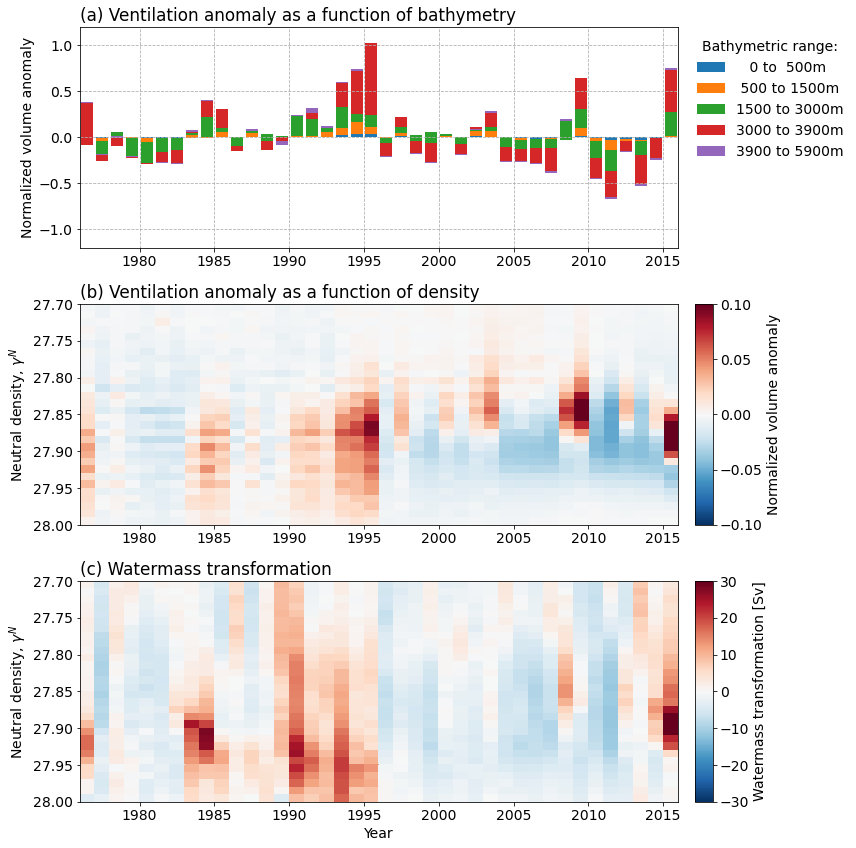

In [21]:
fig = plt.figure(figsize=(12,12),constrained_layout=False)
gs = gridspec.GridSpec(ncols=1, nrows=3, figure=fig)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])
ax2 = fig.add_subplot(gs[2, :])

xlims = [yrst+18,yrend]
ylims_bathy = [-1.2, 1.2]
clims_lag = [-0.1,0.1]
clims_eul = [-30,30]
hgap = 0.02

ax0.set_title('(a) Ventilation anomaly as a function of bathymetry',loc='left')
ax1.set_title('(b) Ventilation anomaly as a function of density',loc='left')
ax2.set_title('(c) Watermass transformation',loc='left')

# Bathymetry
bottom = np.zeros(shape=(len(df['years'])))
count=0
for b in bathys_c:
    if b==bathys_c[-1]:
        # Because range of bathys designed to capture all levels, need to taper in lat value
        depthrange = str('{:4.0f}'.format(np.round(depth[bathys[count]-1].values,-2)))+' to '+str('{:4.0f}'.format(np.round(depth[bathys[count+1]-2].values,-2))+'m')
    else:
        depthrange = str('{:4.0f}'.format(np.round(depth[bathys[count]-1].values,-2)))+' to '+str('{:4.0f}'.format(np.round(depth[bathys[count+1]-1].values,-2))+'m')
        count+=1
        
    ax0.bar(df['years'],df[str(b)],bottom=bottom,label=depthrange)
    bottom += df[str(b)]
ax0.set_xlim(xlims)
ax0.set_ylim(ylims_bathy)
ax0.set_ylabel('Normalized volume anomaly')
ax0.legend(title='Bathymetric range:',frameon=False,bbox_to_anchor=(1.01,1))
ax0.grid(linestyle='--')

# Density
im_dens = ax1.pcolormesh(vlag_dens_anom.final_year_bin+0.5, # +0.5 accounts for different plotting procedure of pcolormesh (x defines vertices)
               np.append(vlag_dens_anom.init_dens_bin,28.005)-0.005,
               vlag_dens_anom.transpose(),vmin=clims_lag[0],vmax=clims_lag[1],cmap='RdBu_r')
ax1.invert_yaxis()
ax1.set_xlim(xlims)
ax1.set_ylabel('Neutral density, $\gamma^N$')

# WMT
im_wmt = ax2.pcolormesh(np.append(wmt_anom.year,2016), # Extend by one to incorparte final year
               wmt_anom.dens,
               (wmt_anom*1E-6).transpose(),vmin=clims_eul[0],vmax=clims_eul[1],cmap='RdBu_r')
ax2.invert_yaxis()
ax2.set_xlim(xlims)
ax2.set_xlabel('Year')
ax2.set_ylabel('Neutral density, $\gamma^N$')

plt.tight_layout()

### Add colorbars after tight_layout

pos = ax1.get_position().bounds
cax = fig.add_axes([pos[0]+pos[2]+hgap, pos[1], hgap, pos[3]]) 
cb = plt.colorbar(im_dens, ax=ax1, cax = cax)
cb.set_label('Normalized volume anomaly')

pos = ax2.get_position().bounds
cax = fig.add_axes([pos[0]+pos[2]+hgap, pos[1], hgap, pos[3]]) 
cb = plt.colorbar(im_wmt, ax=ax2, cax = cax)
cb.set_label('Watermass transformation [Sv]')

fig.savefig('figures/fig_bathy-anom.png',dpi=300,transparent=True)

Text(0, 0.5, 'Normalized volume anomaly')

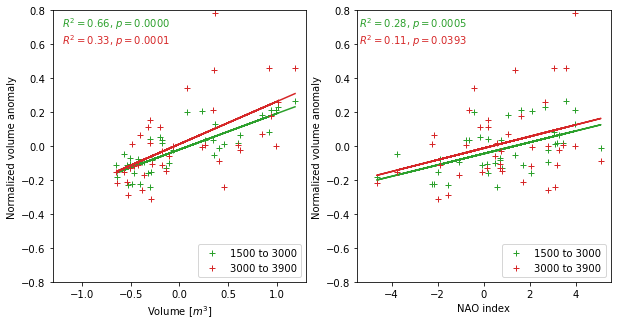

In [10]:
## PANEL: Regression (mixed layer volume anomaly)
xlims=[-1.3,1.3]
ylims = [-0.8,0.8]
color_b1 = 'tab:green'
color_b2 = 'tab:red'

fig,(ax_regress1,ax_regress2) = plt.subplots(figsize=(10,5),ncols=2)

result = sm.ols(formula='Q("55.5") ~ vmld_anom', data=df).fit()
ax_regress1.plot(1E-15*df['vmld_anom'],df['55.5'],'+',color=color_b1,label='1500 to 3000')
ax_regress1.plot(1E-15*df['vmld_anom'],result.params.Intercept+result.params.vmld_anom*df['vmld_anom'],'-',color=color_b1)
ax_regress1.text(xlims[0]+0.1,ylims[1]-0.1,
                 '$R^2 = $'+str('{0:.2f}'.format(result.rsquared))+', $p = $'+str('{0:.4f}'.format(result.f_pvalue)),
                 color=color_b1)
result = sm.ols(formula='Q("62.5") ~ vmld_anom', data=df).fit()
ax_regress1.plot(1E-15*df['vmld_anom'],df['62.5'],'+',color=color_b2,label='3000 to 3900')
ax_regress1.plot(1E-15*df['vmld_anom'],result.params.Intercept+result.params.vmld_anom*df['vmld_anom'],'-',color=color_b2)
ax_regress1.text(xlims[0]+0.1,ylims[1]-0.2,
                 '$R^2 = $'+str('{0:.2f}'.format(result.rsquared))+', $p = $'+str('{0:.4f}'.format(result.f_pvalue)),
                 color=color_b2)

ax_regress1.legend(loc='lower right')
ax_regress1.set_xlim(xlims)
ax_regress1.set_xlabel('Volume [$m^3$]')
ax_regress1.set_ylim(ylims)
ax_regress1.set_ylabel('Normalized volume anomaly')

## PANEL: Regression (NAO)
xlims=[-5.5,5.5]
ylims = [-0.8,0.8]
color_b1 = 'tab:green'
color_b2 = 'tab:red'

result = sm.ols(formula='Q("55.5") ~ nao', data=df).fit()
ax_regress2.plot(df['nao'],df['55.5'],'+',color=color_b1,label='1500 to 3000')
ax_regress2.plot(df['nao'],result.params.Intercept+result.params.nao*df['nao'],'-',color=color_b1)
ax_regress2.text(xlims[0]+0.1,ylims[1]-0.1,
                 '$R^2 = $'+str('{0:.2f}'.format(result.rsquared))+', $p = $'+str('{0:.4f}'.format(result.f_pvalue)),
                 color=color_b1)
result = sm.ols(formula='Q("62.5") ~ nao', data=df).fit()
ax_regress2.plot(df['nao'],df['62.5'],'+',color=color_b2,label='3000 to 3900')
ax_regress2.plot(df['nao'],result.params.Intercept+result.params.nao*df['nao'],'-',color=color_b2)
ax_regress2.text(xlims[0]+0.1,ylims[1]-0.2,
                 '$R^2 = $'+str('{0:.2f}'.format(result.rsquared))+', $p = $'+str('{0:.4f}'.format(result.f_pvalue)),
                 color=color_b2)

ax_regress2.legend(loc='lower right')
ax_regress2.set_xlim(xlims)
ax_regress2.set_xlabel('NAO index')
ax_regress2.set_ylim(ylims)
ax_regress2.set_ylabel('Normalized volume anomaly')